In [1]:
import os
import math
import mxnet as mx
from mxnet import image
from mxnet import nd, gluon, autograd, init
from mxnet.gluon.data.vision import ImageFolderDataset
from mxnet.gluon.data import DataLoader
from mxnet.gluon import nn
from tensorboardX import SummaryWriter
import numpy as np
import shutil
import _pickle as cPickle
import gzip
from sklearn import preprocessing
from mxnet.gluon.parameter import Parameter, ParameterDict
from common.util import download_file
import subprocess
import time

from IPython.core.debugger import Tracer

In [2]:
class Options:
    def __init__(self):
        self.seed_val = 0
        self.num_train_sup = 50000
        self.batch_size = 512
        self.data_dir = '/tanData/datasets/mnist'
        self.log_dir = '/tanData/logs_mnist'
        self.model_dir ='/tanData/models'
        self.exp_name = 'mnist_nlabels_%i_lenet_lddrm_pathnorm_seed_%i_fc256'%(self.num_train_sup, self.seed_val)
        # self.exp_name = 'mnist_nlabels_%i_lenet_lddrm_pathnorm_seed_%i'%(self.num_train_sup, self.seed_val)
        self.ctx = mx.gpu(0)
        self.alpha_drm = 0.2
        self.alpha_pn = 0.75
        self.alpha_kl = 1.0
        self.alpha_nn = 0.2
        self.filename = '%s/%s_best.params'%(self.model_dir, self.exp_name)
        
        self.use_bias = True
        self.use_bn = True
        self.do_topdown = True
        self.do_countpath = False
        self.do_pn = True
        self.relu_td = False
        self.do_nn = True

opt = Options()

In [3]:
def gpu_device(ctx=mx.gpu(0)):
    try:
        _ = mx.nd.array([1, 2, 3], ctx=ctx)
    except mx.MXNetError:
        return None
    return ctx

assert gpu_device(opt.ctx), 'No GPU device found!'

In [4]:
# Preparing the data step 1
f = gzip.open(os.path.join(opt.data_dir,'mnist.pkl.gz'), 'rb')
train_set, valid_set, test_set = cPickle.load(f, encoding='bytes')
f.close()

trainx = train_set[0]
trainy = train_set[1]

testx = test_set[0]
testy = test_set[1]
Ntest = np.shape(testx)[0]

validx = valid_set[0]
validy = valid_set[1]
Nvalid = np.shape(validx)[0]

trainx = np.concatenate([trainx, validx], axis=0)
trainy = np.concatenate([trainy, validy], axis=0)

num_train = np.shape(trainx)[0]

indx = np.random.permutation(range(0, num_train))

trainx = (trainx[indx] - 0.13015033)/0.30690455
trainy = trainy[indx]
testx = (testx - 0.13015033)/0.3069045

trainx = np.reshape(trainx, newshape=(trainx.shape[0], 1 , 28, 28))
testx = np.reshape(testx, newshape=(testx.shape[0], 1 , 28, 28))

trainx = nd.array(trainx, ctx=opt.ctx)
testx = nd.array(testx, ctx=opt.ctx)
trainy = nd.array(trainy, ctx=opt.ctx)
testy = nd.array(testy, ctx=opt.ctx)

In [5]:
# from resnet import ResNet164_v2
from mxnet.gluon.model_zoo import vision as models
from lenet_ld_opt import VGG_DRM

In [6]:
# visualize an MNIST image
import matplotlib.pyplot as plt

def show_image(x, cmap, interpolation):
    plt.figure()
    plt.imshow(x, cmap=cmap, interpolation=interpolation)
    plt.axis('off')
    plt.show()

def visualize_layer(model, img_indx, num_layer, testx, testy, cmap, interpolation):
    num_img = len(img_indx)
    for i in range(num_img):
        print('Original Image %i'%i)
        plt.figure()
        show_image(x=(testx.asnumpy())[img_indx[i]][0], cmap='hot', interpolation='bicubic')
        for j in range(num_layer):
            print('layer %i: %s'%(j,model.drm._children[j].name))
            x = model.reconstruct_at_level(nd.expand_dims(testx[img_indx[i]], axis=0), testy[img_indx[i]], opt.ctx, j)
            # x = model.reconstruct(nd.expand_dims(testx[0], axis=0), i*nd.ones((1,), ctx=opt.ctx), opt.ctx)
            x = x.asnumpy()
            print('image size = %i %i %i %i'%x.shape)
            if x.shape[2] > 1:
                x = np.mean(x, axis=1, keepdims=True)
                xshow = x[0,0]
            else:
                xshow = x[0,:,:,0]
                if x.shape[1] > 10:
                    xshow = np.reshape(xshow, (16,16))
            
            show_image(xshow, cmap=cmap, interpolation=interpolation)
            
def visualize_featuremap(model, img_indx, num_layer, testx, testy, cmap, interpolation):
    num_img = len(img_indx)
    for i in range(num_img):
        print('Original Image %i'%i)
        show_image(x=(testx.asnumpy())[img_indx[i]][0], cmap='hot', interpolation='bicubic')
        
        for j in range(num_layer):
            print('layer %i: %s'%(j,model.drm._children[j].name))
            x = model.reconstruct_at_level(nd.expand_dims(testx[img_indx[i]], axis=0), testy[img_indx[i]], opt.ctx, j)
            # x = model.reconstruct(nd.expand_dims(testx[0], axis=0), i*nd.ones((1,), ctx=opt.ctx), opt.ctx)
            x = x.asnumpy()
            print('image size = %i %i %i %i'%x.shape)
            if x.shape[2] > 1:
                if model.drm._children[j].name.find('avg') != -1:
                    x = np.mean(x, axis=1, keepdims=True)
                    xshow = x[0,0]
                    show_image(xshow, cmap=cmap, interpolation=interpolation)
                else:
                    for k in range(x.shape[1]):
                        print('feature map %i'%k)
                        xshow = x[0,k]
                        show_image(xshow, cmap=cmap, interpolation=interpolation)
            else:
                xshow = x[0,:,:,0]
                if x.shape[1] > 10:
                    xshow = np.reshape(xshow, (16,16))
                show_image(xshow, cmap=cmap, interpolation=interpolation)
    
    
def run_generate():
    model = VGG_DRM('ConvSmallMNIST256', batch_size=opt.batch_size, num_class=10, use_bias=opt.use_bias, use_bn=opt.use_bn, do_topdown=opt.do_topdown, do_countpath=opt.do_countpath, do_pn=opt.do_pn, relu_td=opt.relu_td, do_nn=opt.do_nn)
    model.collect_params().load(opt.filename, ctx=opt.ctx)
    num_layer = len(model.drm._children)
    img_indx = []
    y = 0.0
    for i in range(len(testy)):
        if testy[i].asnumpy()[0] == y:
            img_indx.append(i)
            y += 1.0
        if y > 9.0:
            break
    visualize_layer(model=model, img_indx=img_indx, num_layer=num_layer, testx=testx, testy=testy, cmap='hot', interpolation='bicubic')
    #visualize_featuremap(model=model, img_indx=[img_indx[5],], num_layer=num_layer, testx=testx, testy=testy, cmap='hot', interpolation='bicubic')
            
        
#     # x = model.generate(i*nd.ones((1,), ctx=opt.ctx), opt.ctx)
#     x = model.reconstruct(nd.expand_dims(testx[0], axis=0), testy[0], opt.ctx)
#     x = x.asnumpy()
#     #plt.figure()
#     #plt.imshow((testx.asnumpy())[i][0], cmap='gray')
#     plt.figure()
#     plt.imshow(x[0,0], cmap='gray')
#     for i in range(10):
#         # x = model.generate(i*nd.ones((1,), ctx=opt.ctx), opt.ctx)
#         x = model.reconstruct(nd.expand_dims(testx[i], axis=0), testy[i], opt.ctx)
#         # x = model.reconstruct(nd.expand_dims(testx[0], axis=0), i*nd.ones((1,), ctx=opt.ctx), opt.ctx)
#         x = x.asnumpy()
#         #plt.figure()
#         #plt.imshow((testx.asnumpy())[i][0], cmap='gray')
#         plt.figure()
#         plt.imshow(x[0,0], cmap='gray')

Original Image 0


<Figure size 432x288 with 0 Axes>

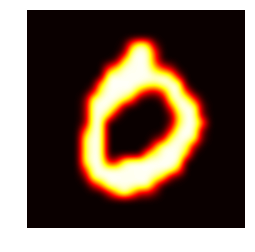

layer 0: reshape0
image size = 1 10 1 1


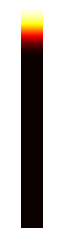

layer 1: conv8
image size = 1 256 1 1


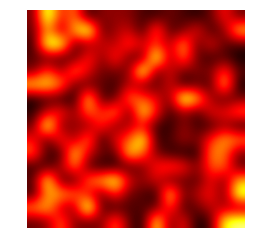

layer 2: batchnorm8
image size = 1 256 1 1


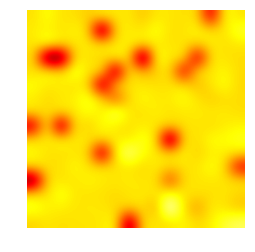

layer 3: avg
image size = 1 256 6 6


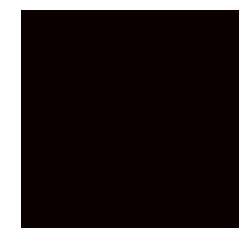

layer 4: conv7
image size = 1 64 8 8


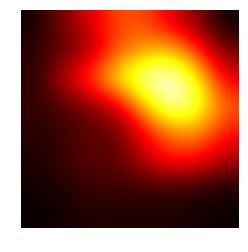

layer 5: batchnorm6
image size = 1 64 8 8


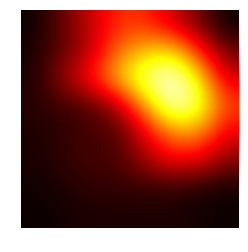

layer 6: upsamplelayer1
image size = 1 64 16 16


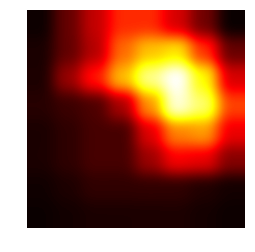

layer 7: conv5
image size = 1 64 14 14


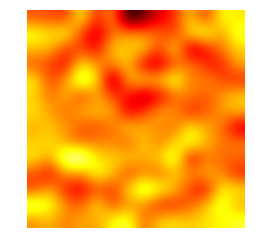

layer 8: batchnorm5
image size = 1 64 14 14


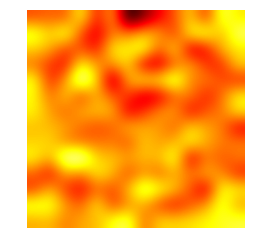

layer 9: conv3
image size = 1 32 16 16


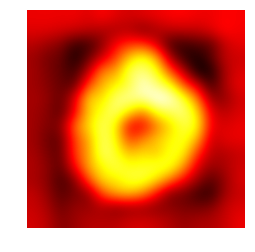

layer 10: batchnorm2
image size = 1 32 16 16


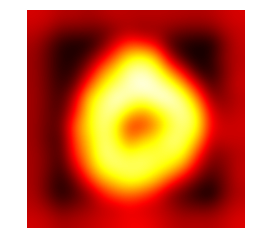

layer 11: upsamplelayer0
image size = 1 32 32 32


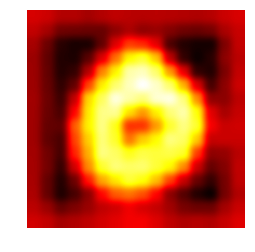

layer 12: conv1
image size = 1 1 28 28


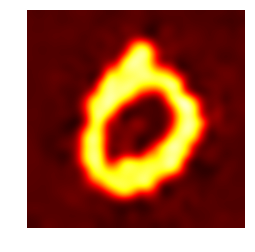

layer 13: batchnorm1
image size = 1 1 28 28


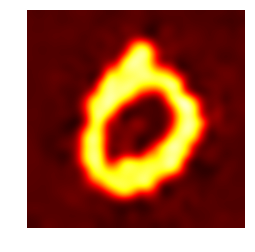

Original Image 1


<Figure size 432x288 with 0 Axes>

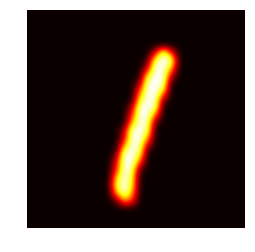

layer 0: reshape0
image size = 1 10 1 1


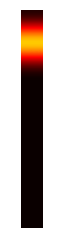

layer 1: conv8
image size = 1 256 1 1


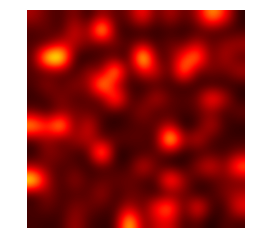

layer 2: batchnorm8
image size = 1 256 1 1


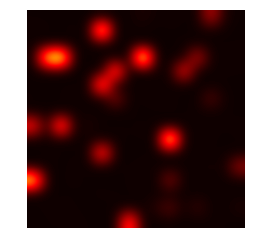

layer 3: avg
image size = 1 256 6 6


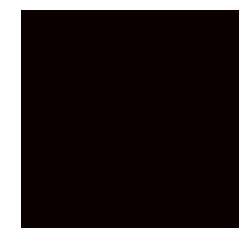

layer 4: conv7
image size = 1 64 8 8


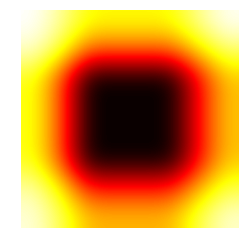

layer 5: batchnorm6
image size = 1 64 8 8


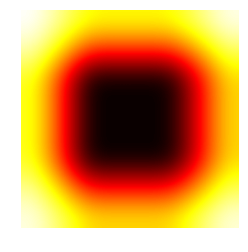

layer 6: upsamplelayer1
image size = 1 64 16 16


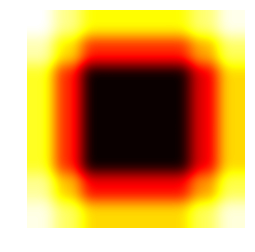

layer 7: conv5
image size = 1 64 14 14


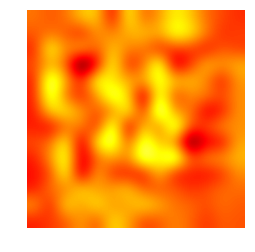

layer 8: batchnorm5
image size = 1 64 14 14


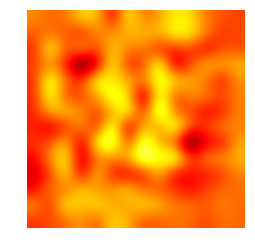

layer 9: conv3
image size = 1 32 16 16


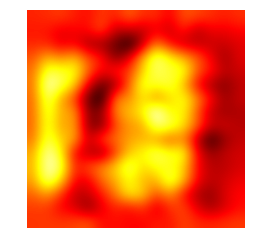

layer 10: batchnorm2
image size = 1 32 16 16


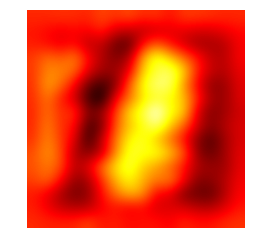

layer 11: upsamplelayer0
image size = 1 32 32 32


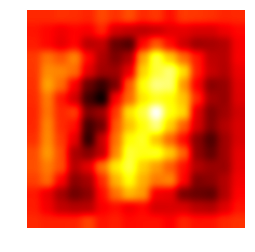

layer 12: conv1
image size = 1 1 28 28


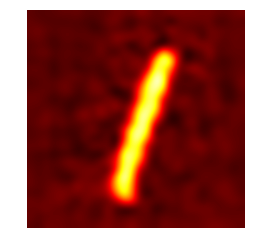

layer 13: batchnorm1
image size = 1 1 28 28


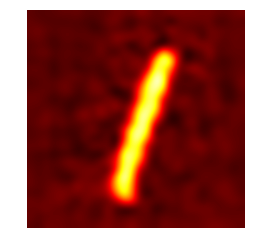

Original Image 2


<Figure size 432x288 with 0 Axes>

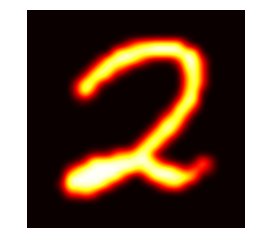

layer 0: reshape0
image size = 1 10 1 1


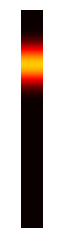

layer 1: conv8
image size = 1 256 1 1


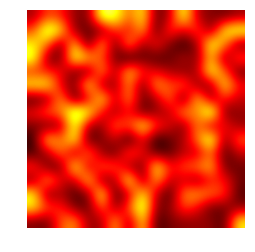

layer 2: batchnorm8
image size = 1 256 1 1


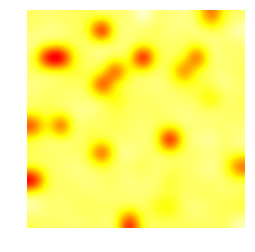

layer 3: avg
image size = 1 256 6 6


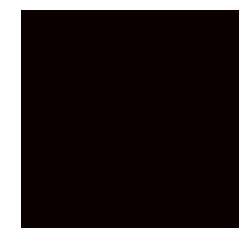

layer 4: conv7
image size = 1 64 8 8


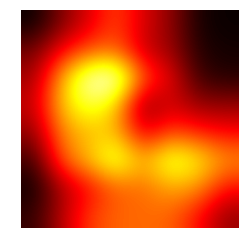

layer 5: batchnorm6
image size = 1 64 8 8


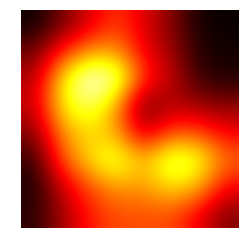

layer 6: upsamplelayer1
image size = 1 64 16 16


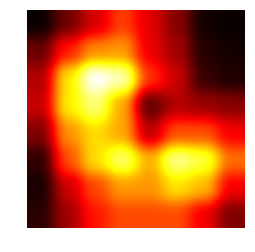

layer 7: conv5
image size = 1 64 14 14


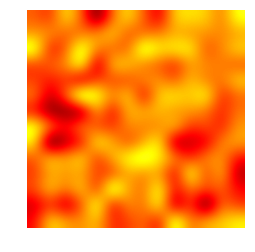

layer 8: batchnorm5
image size = 1 64 14 14


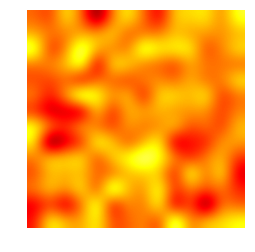

layer 9: conv3
image size = 1 32 16 16


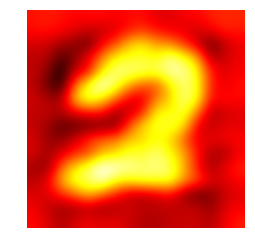

layer 10: batchnorm2
image size = 1 32 16 16


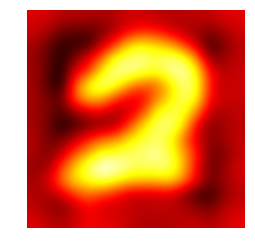

layer 11: upsamplelayer0
image size = 1 32 32 32


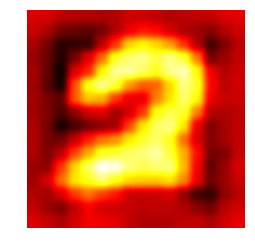

layer 12: conv1
image size = 1 1 28 28


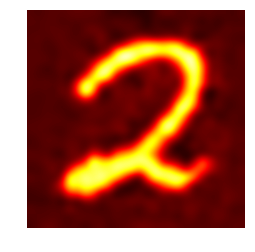

layer 13: batchnorm1
image size = 1 1 28 28


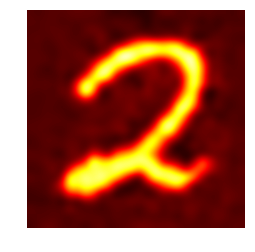

Original Image 3


<Figure size 432x288 with 0 Axes>

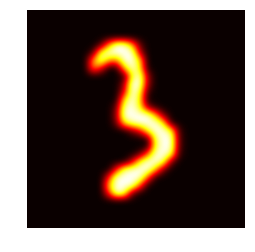

layer 0: reshape0
image size = 1 10 1 1


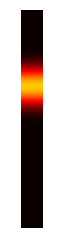

layer 1: conv8
image size = 1 256 1 1


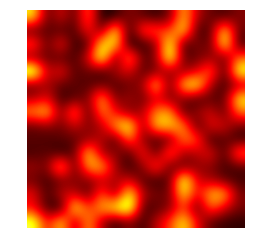

layer 2: batchnorm8
image size = 1 256 1 1


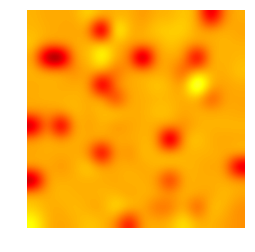

layer 3: avg
image size = 1 256 6 6


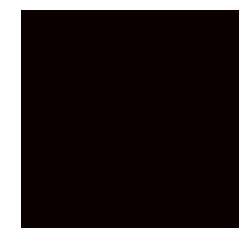

layer 4: conv7
image size = 1 64 8 8


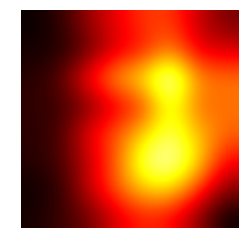

layer 5: batchnorm6
image size = 1 64 8 8


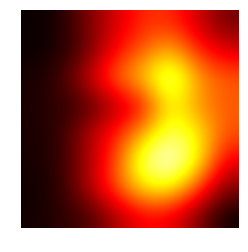

layer 6: upsamplelayer1
image size = 1 64 16 16


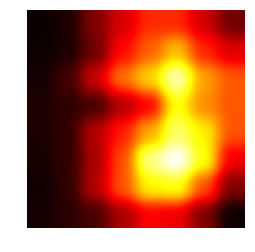

layer 7: conv5
image size = 1 64 14 14


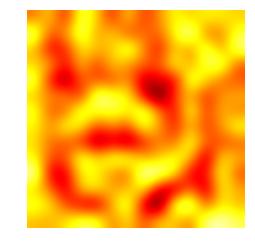

layer 8: batchnorm5
image size = 1 64 14 14


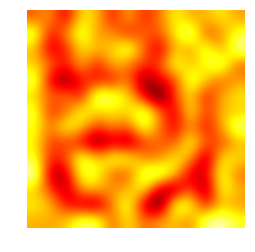

layer 9: conv3
image size = 1 32 16 16


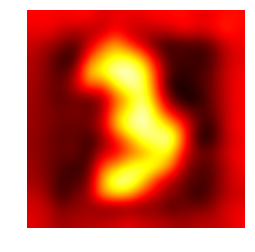

layer 10: batchnorm2
image size = 1 32 16 16


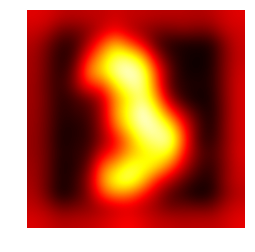

layer 11: upsamplelayer0
image size = 1 32 32 32


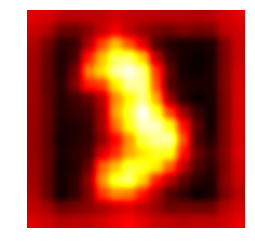

layer 12: conv1
image size = 1 1 28 28


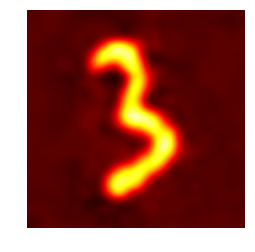

layer 13: batchnorm1
image size = 1 1 28 28


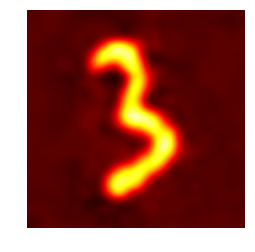

Original Image 4


<Figure size 432x288 with 0 Axes>

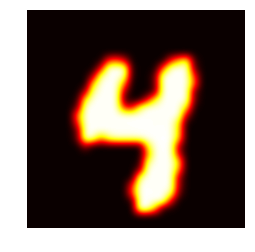

layer 0: reshape0
image size = 1 10 1 1


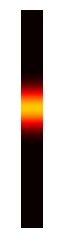

layer 1: conv8
image size = 1 256 1 1


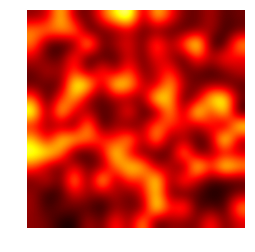

layer 2: batchnorm8
image size = 1 256 1 1


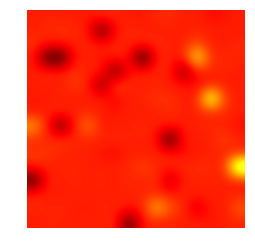

layer 3: avg
image size = 1 256 6 6


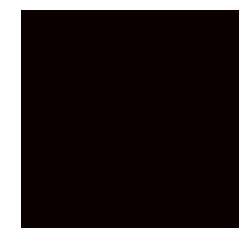

layer 4: conv7
image size = 1 64 8 8


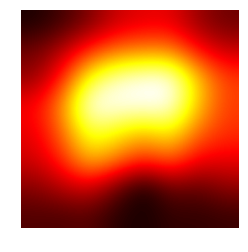

layer 5: batchnorm6
image size = 1 64 8 8


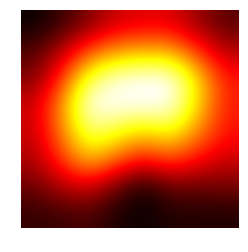

layer 6: upsamplelayer1
image size = 1 64 16 16


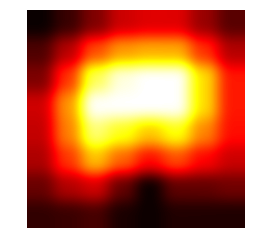

layer 7: conv5
image size = 1 64 14 14


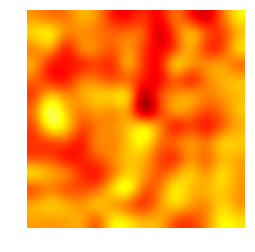

layer 8: batchnorm5
image size = 1 64 14 14


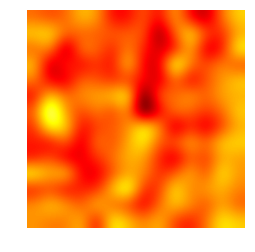

layer 9: conv3
image size = 1 32 16 16


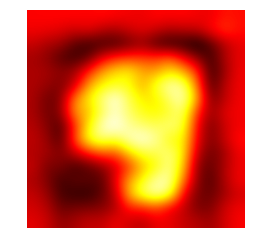

layer 10: batchnorm2
image size = 1 32 16 16


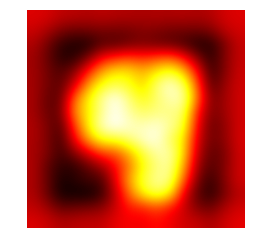

layer 11: upsamplelayer0
image size = 1 32 32 32


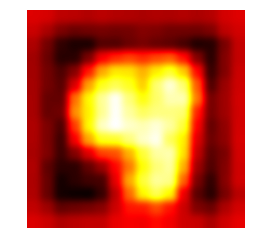

layer 12: conv1
image size = 1 1 28 28


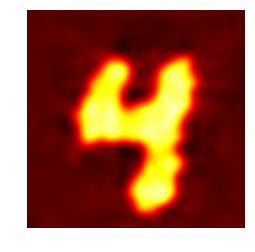

layer 13: batchnorm1
image size = 1 1 28 28


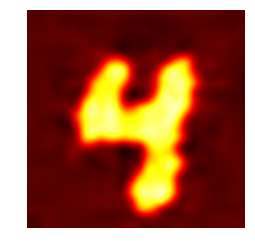

Original Image 5


<Figure size 432x288 with 0 Axes>

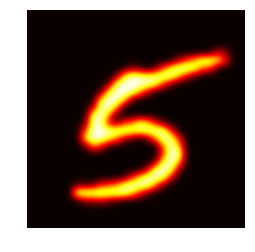

layer 0: reshape0
image size = 1 10 1 1


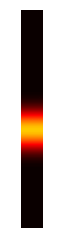

layer 1: conv8
image size = 1 256 1 1


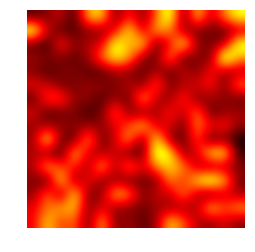

layer 2: batchnorm8
image size = 1 256 1 1


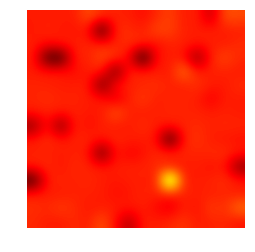

layer 3: avg
image size = 1 256 6 6


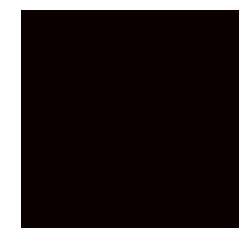

layer 4: conv7
image size = 1 64 8 8


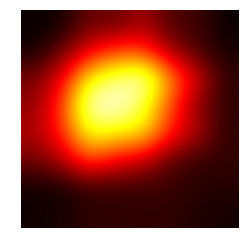

layer 5: batchnorm6
image size = 1 64 8 8


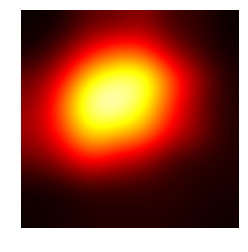

layer 6: upsamplelayer1
image size = 1 64 16 16


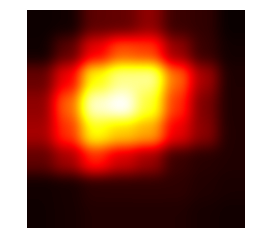

layer 7: conv5
image size = 1 64 14 14


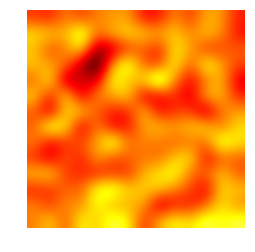

layer 8: batchnorm5
image size = 1 64 14 14


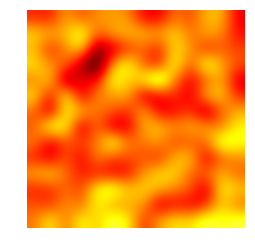

layer 9: conv3
image size = 1 32 16 16


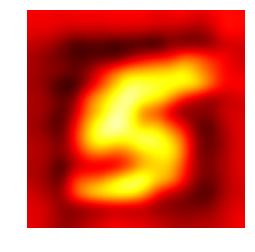

layer 10: batchnorm2
image size = 1 32 16 16


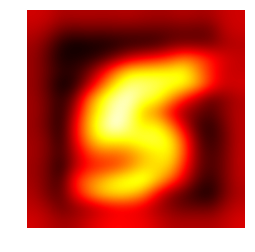

layer 11: upsamplelayer0
image size = 1 32 32 32


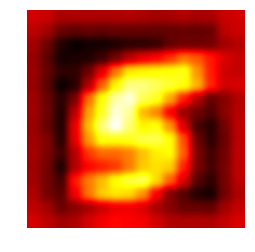

layer 12: conv1
image size = 1 1 28 28


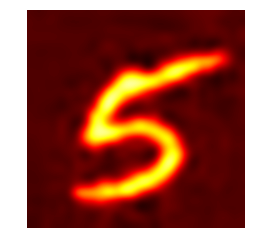

layer 13: batchnorm1
image size = 1 1 28 28


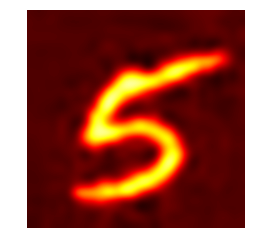

Original Image 6


<Figure size 432x288 with 0 Axes>

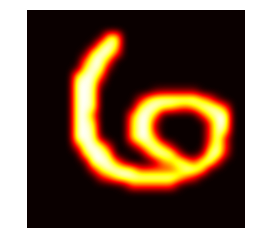

layer 0: reshape0
image size = 1 10 1 1


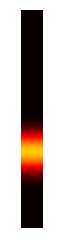

layer 1: conv8
image size = 1 256 1 1


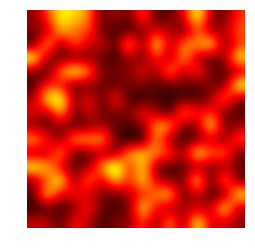

layer 2: batchnorm8
image size = 1 256 1 1


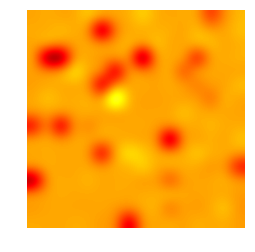

layer 3: avg
image size = 1 256 6 6


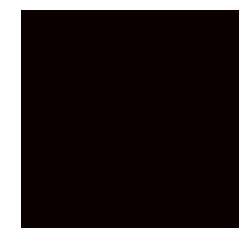

layer 4: conv7
image size = 1 64 8 8


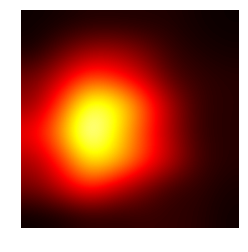

layer 5: batchnorm6
image size = 1 64 8 8


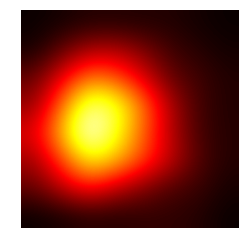

layer 6: upsamplelayer1
image size = 1 64 16 16


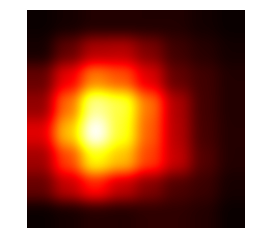

layer 7: conv5
image size = 1 64 14 14


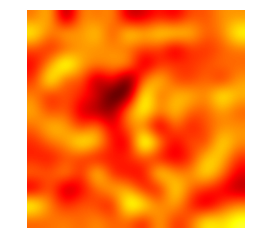

layer 8: batchnorm5
image size = 1 64 14 14


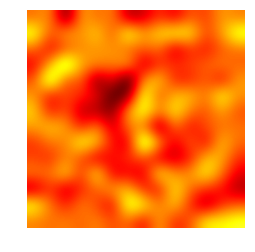

layer 9: conv3
image size = 1 32 16 16


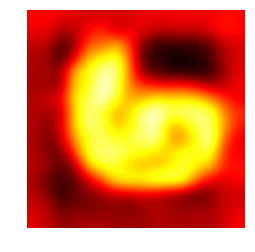

layer 10: batchnorm2
image size = 1 32 16 16


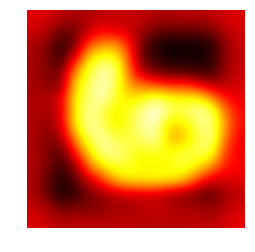

layer 11: upsamplelayer0
image size = 1 32 32 32


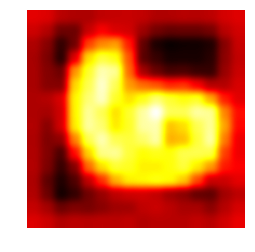

layer 12: conv1
image size = 1 1 28 28


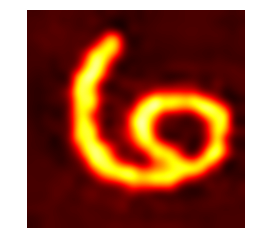

layer 13: batchnorm1
image size = 1 1 28 28


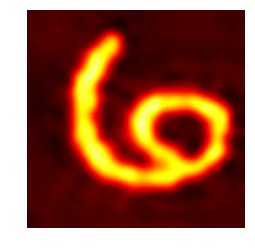

Original Image 7


<Figure size 432x288 with 0 Axes>

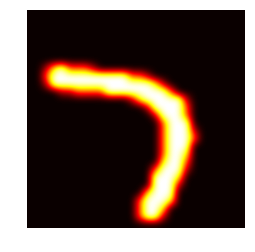

layer 0: reshape0
image size = 1 10 1 1


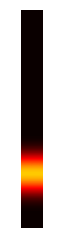

layer 1: conv8
image size = 1 256 1 1


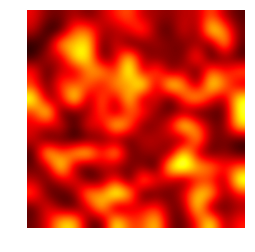

layer 2: batchnorm8
image size = 1 256 1 1


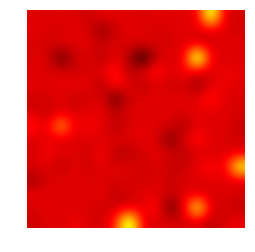

layer 3: avg
image size = 1 256 6 6


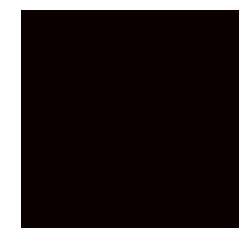

layer 4: conv7
image size = 1 64 8 8


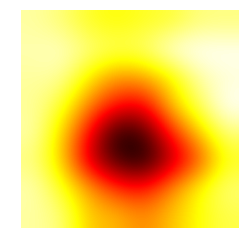

layer 5: batchnorm6
image size = 1 64 8 8


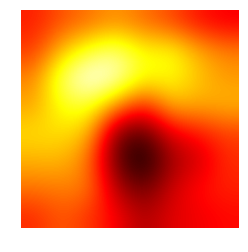

layer 6: upsamplelayer1
image size = 1 64 16 16


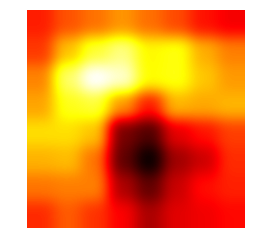

layer 7: conv5
image size = 1 64 14 14


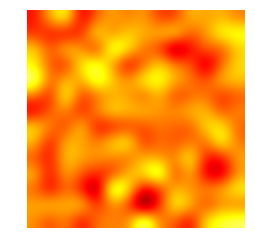

layer 8: batchnorm5
image size = 1 64 14 14


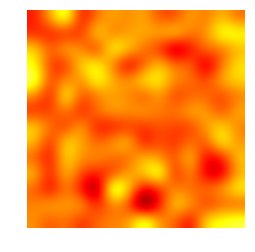

layer 9: conv3
image size = 1 32 16 16


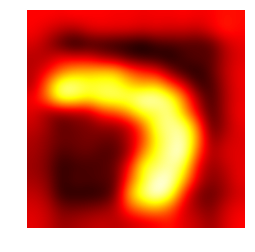

layer 10: batchnorm2
image size = 1 32 16 16


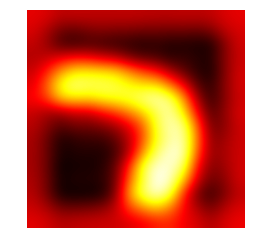

layer 11: upsamplelayer0
image size = 1 32 32 32


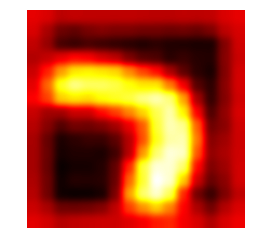

layer 12: conv1
image size = 1 1 28 28


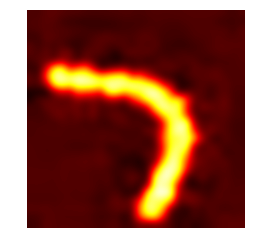

layer 13: batchnorm1
image size = 1 1 28 28


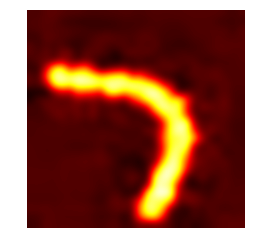

Original Image 8


<Figure size 432x288 with 0 Axes>

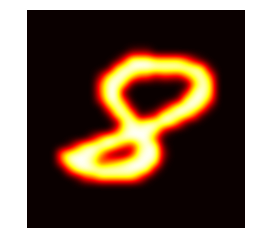

layer 0: reshape0
image size = 1 10 1 1


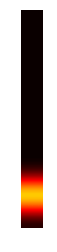

layer 1: conv8
image size = 1 256 1 1


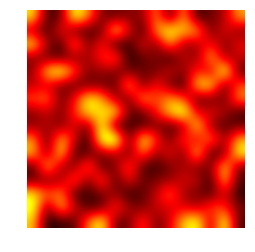

layer 2: batchnorm8
image size = 1 256 1 1


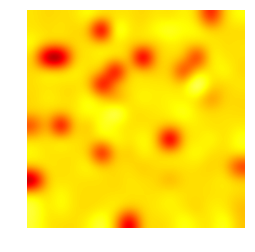

layer 3: avg
image size = 1 256 6 6


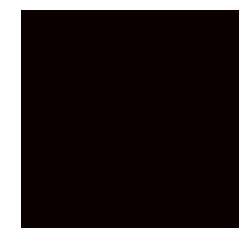

layer 4: conv7
image size = 1 64 8 8


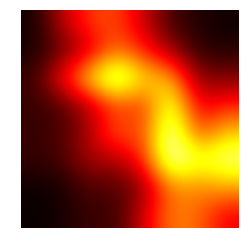

layer 5: batchnorm6
image size = 1 64 8 8


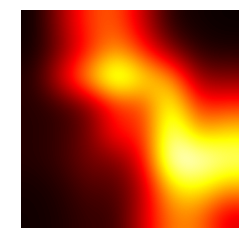

layer 6: upsamplelayer1
image size = 1 64 16 16


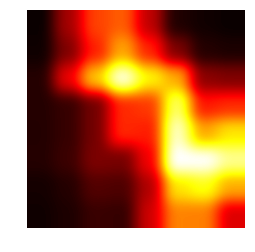

layer 7: conv5
image size = 1 64 14 14


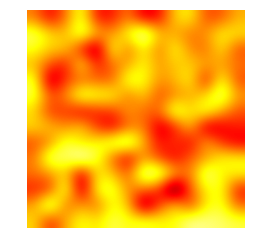

layer 8: batchnorm5
image size = 1 64 14 14


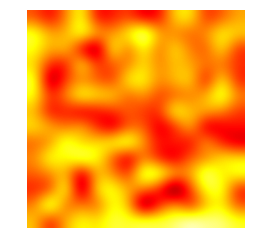

layer 9: conv3
image size = 1 32 16 16


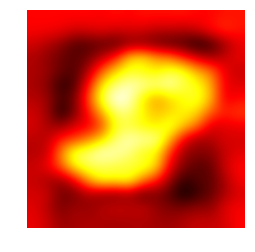

layer 10: batchnorm2
image size = 1 32 16 16


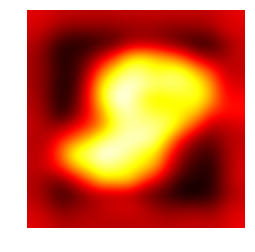

layer 11: upsamplelayer0
image size = 1 32 32 32


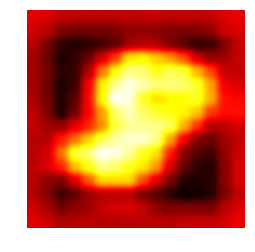

layer 12: conv1
image size = 1 1 28 28


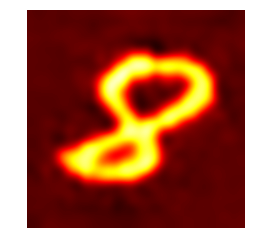

layer 13: batchnorm1
image size = 1 1 28 28


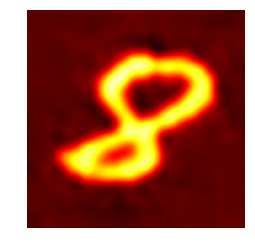

Original Image 9


<Figure size 432x288 with 0 Axes>

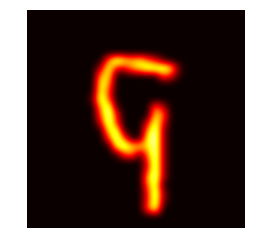

layer 0: reshape0
image size = 1 10 1 1


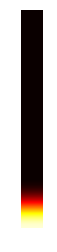

layer 1: conv8
image size = 1 256 1 1


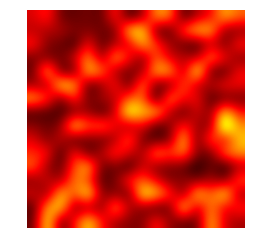

layer 2: batchnorm8
image size = 1 256 1 1


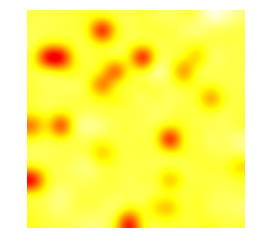

layer 3: avg
image size = 1 256 6 6


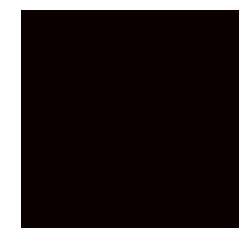

layer 4: conv7
image size = 1 64 8 8


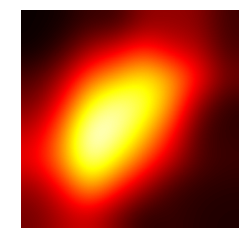

layer 5: batchnorm6
image size = 1 64 8 8


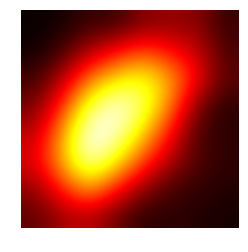

layer 6: upsamplelayer1
image size = 1 64 16 16


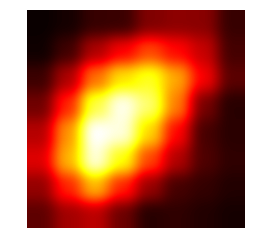

layer 7: conv5
image size = 1 64 14 14


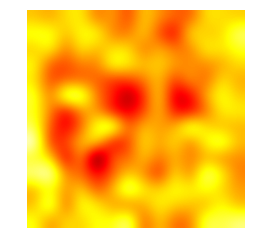

layer 8: batchnorm5
image size = 1 64 14 14


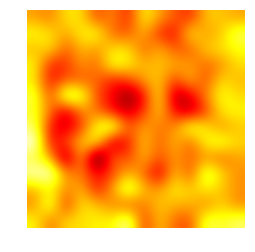

layer 9: conv3
image size = 1 32 16 16


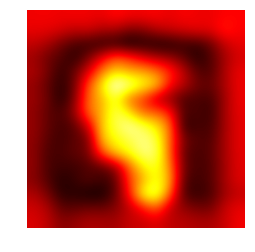

layer 10: batchnorm2
image size = 1 32 16 16


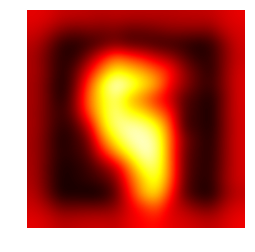

layer 11: upsamplelayer0
image size = 1 32 32 32


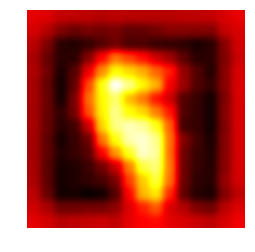

layer 12: conv1
image size = 1 1 28 28


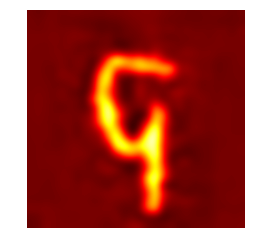

layer 13: batchnorm1
image size = 1 1 28 28


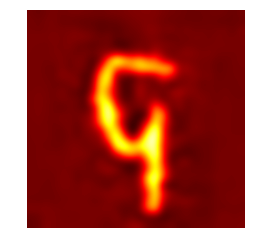

In [7]:
run_generate()